<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/Noisy0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil

# Function to clear the "figures" directory
def clear_figures_directory():
    if os.path.exists("figures"):
        shutil.rmtree("figures")
    if os.path.exists("Saved_Trained_Checkpoints"):
        shutil.rmtree("Saved_Trained_Checkpoints")

# Call the function to clear the "figures" directory before starting the training loop
clear_figures_directory()




In [ ]:
%reset -f

In [ ]:
!pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00


In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.3 MB/s eta 0:00:00


In [ ]:

!pip install torchsummary

In [ ]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [ ]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 254531665.12it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119463208.90it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 148314205.37it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13656293.02it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
class SAE(nn.Module):

    # def set_beta_syn(self, beta_syn):
    #     self.beta_syn = beta_syn

    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                                # bias=True, padding_mode='zeros',  device=None, dtype=None)
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha1, beta=beta1, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha11, beta=beta11, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data

        #ve from the flattened encoded representation (latent_dim) back to a tensor representation to
            # use in transposed convolution.
          # To do so, we need to run an additional fully-connected linear layer transforming the data back into a tensor of 128 x 4 x 4:

        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))
                                      #snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))




      #  The decoder, with three transposed convolutional (nn.ConvTranspose2d) layers and one linear output layer.
      # Although we converted the latent data back into tensor form for convolution, we still need to Unflatten it to a tensor of 128 x 4 x 4,
        # as the input to the network is 1 dimensional.  This is done using nn.Unflatten in the first line of the Decoder:
        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha2, beta=beta2, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha22, beta=beta22, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
        # final Leaky layer, our spiking threshold (thresh) is set extremely high. This is a neat trick in snnTorch, which allows the neuron
        # membrane in the final layer to continuously be updated, without ever reaching a spiking threshold.

        # using the membrane potential output from the final layer for the image reconstruction.
            # snnTorch allows us to use either the spikes or membrane potential of each neuron in training.



    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)
    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        encoder_mem=[];
        for step in range(num_steps): #for t in time
            spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension
        # torch.stack joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension.
        # print("Size of spk_rec:", spk_rec.size())   # Size of spk_rec: torch.Size([250, 32, 5])
        # print("Size of spk_mem:", spk_mem.size()) # Size of spk_mem: torch.Size([250, 32, 5])
        out_e = spk_rec[:,:,-1]
    #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        for step in range(num_steps): #for t in time
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])

            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)
        out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        # print("Size of spk_rec2:", spk_rec2.size())  #Size of spk_rec2: torch.Size([250, 1, 32, 32, 5])
        # print("Size of spk_mem2:", spk_mem2.size())  # Size of spk_mem2: torch.Size([250, 1, 32, 32, 5]),
        # print("Size of spk_mem2[:,:,:,:,-1]:", out.size())  # Size of spk_mem2[:,:,:,:,-1]: torch.Size([250, 1, 32, 32])

        # Plotting the raster plots
        # plt.figure(figsize=(10, 8))
        # plt.title("Encoder spk_mem[:, i]")

        for i in range(31):
          # plt.eventplot(spk_mem[:, i].nonzero().cpu(), lineoffsets=i+1, linelengths=0.5)
          encoder_mem.append(spk_mem[:, i].nonzero().cpu())

        # plt.eventplot(spk_mem[:, :, -1].nonzero().cpu(), lineoffsets=1, linelengths=0.5)
        # plt.xlabel("Time step")
        # plt.ylabel("Neuron")
        # plt.show()

        return out, encoder_mem


    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x

    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2


In [ ]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5
std_dev=0.1


def train(network, trainloader, opti, epoch):
    spk_rec_batches = []  # List to store spk_rec batches

    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]
    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)

        # Add Gaussian noise to the input images
        real_img = real_img + torch.randn_like(real_img) * std_dev
        # real_img = real_img + torch.randn(real_img.size()) * 0.1

        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        # x_recon = network(real_img) #Dimensions passed in: [Batch_size,Input_size,Image_Width,Image_Length]
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec

        #Calculate loss
        # Avg Loss:
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        # avg_loss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()

        # # ---------------------------- Calculate Bit Error Rate (BER)
        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

        # --------------------------------------------------------------

        # # Print train/test loss/accuracy
        # if counter % 50 == 0:
        # print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')
        # # counter += 1
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            # NOTE: you need to create training/ and testing/ folders in your chosen path
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

    # return loss_val, train_loss_rec , train_auc , spk_rec_batches #, train_avg_loss_rec, #avg_loss #, train_loss_hist
    return loss_val, train_loss_rec , train_auc , out  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist


def plot_spk_rec(spk_rec_batches):
    num_batches = len(spk_rec_batches)
    for batch_idx in range(num_batches):
        spk_rec_batch = spk_rec_batches[batch_idx]
        batch_size, _, num_steps = spk_rec_batch.size()
        for i in range(batch_size):
            plt.figure()
            for step in range(num_steps):
                plt.subplot(batch_size, num_steps, i * num_steps + step + 1)
                plt.imshow(spk_rec_batch[i, :, step].squeeze().numpy())
                plt.axis("off")
            plt.show()



# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)

            # x_recon = network(real_img)
            x_recon , out = network(real_img)

            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())

            # #------------------------------------------------------------------  Calculate Bit Error Rate (BER)
            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

            test_loss_rec.append(loss_val.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                # utls.save_image(((torch.randn_like(real_img) * std_dev)+1)/2, f'figures/testing/Noise_epoch{epoch}_finalbatch_inputs.png')
                # utls.save_image((real_img-(torch.randn_like(real_img) * std_dev)+1)/2, f'figures/testing/(real_img-noise)_epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((real_img+(torch.randn_like(real_img) * std_dev)+1)/2, f'figures/testing/(real_img+noise)_epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

    return loss_val, test_loss_rec, test_auc, out,  #spk_rec_test  #, test_avg_loss_rec #, test_loss_hist


In [ ]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CPU


In [ ]:
start_time = datetime.datetime.now()

input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

# //////////////////////////////////range for beta////////////////////////
train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]


# /////////////////////////////////////////////////////////////////////
  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
beta_syn=0.9
beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)



In [ ]:
# Initialize lists to store entropy values during training and testing
train_entropy_rec = []
test_entropy_rec = []



# Set the path for saving checkpoints
checkpoint_path = "Saved_Trained_Checkpoints/"

   #Run training and testing
for e in range(epochs):

  train_loss = train(net, train_loader, optimizer, e)
  # train_loss, train_loss_rec, train_auc, spk_rec_batches = train(net, train_loader, optimizer, e)
  train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

# /////////////////////////////////////////////////////////////////////
      # Save the model every 10 epochs
  if (e + 1) % 10 == 0:
    model_path = checkpoint_path + f"noise_model_epoch_{e + 1}_StdDev_0.1.pt"
    torch.save(net.state_dict(), model_path)

# # ///////////////////////////////////////////////////////////////////////


  test_loss = test(net,test_loader, optimizer, e)
  test_avg_loss_rec.append(sum(test_loss_rec)/(len(test_loader)))



  #   # Calculate and store the entropy for training and testing
  # train_entropy = calculate_entropy(spk_rec_batches)
  # test_entropy = calculate_entropy(net.spk_rec)

  # train_entropy_rec.append(train_entropy)
  # test_entropy_rec.append(test_entropy)



#     # Visualize encoder_mem
#   for i in range(len(encoder_mem)):
#     plt.eventplot(encoder_mem[i].numpy(), lineoffsets=i + 1, linelengths=0.5)
#   plt.xlabel("Time step")
#   plt.ylabel("Neuron")
#   plt.title("Encoder Spike Times")
#   plt.show()

# # encoder_mem_data = net.encoder_mem  # Assuming "encoder_mem" is a member variable of your SAE model
# # for neuron_index, neuron_spikes in enumerate(encoder_mem_data):
# #     plt.figure()
# #     plt.eventplot(neuron_spikes, lineoffsets=neuron_index + 1, linelengths=0.5)
# #     plt.xlabel("Time step")
# #     plt.ylabel("Neuron")
# #     plt.title(f"Spike Membrane Locations - Neuron {neuron_index}")
# #     plt.show()






Streaming output truncated to the last 5000 lines.
Train[32/50][40/240] Loss: 0.12167227268218994, BER : 0.04487890625
Train[32/50][41/240] Loss: 0.12174084037542343, BER : 0.0441171875
Train[32/50][42/240] Loss: 0.12273945659399033, BER : 0.04622265625
Train[32/50][43/240] Loss: 0.12213177233934402, BER : 0.0456953125
Train[32/50][44/240] Loss: 0.1176261305809021, BER : 0.04269921875
Train[32/50][45/240] Loss: 0.11863615363836288, BER : 0.043078125
Train[32/50][46/240] Loss: 0.11598009616136551, BER : 0.04102734375
Train[32/50][47/240] Loss: 0.12042935192584991, BER : 0.04345703125
Train[32/50][48/240] Loss: 0.12031298130750656, BER : 0.04428515625
Train[32/50][49/240] Loss: 0.11800370365381241, BER : 0.04295703125
Train[32/50][50/240] Loss: 0.12018097937107086, BER : 0.0444375
Train[32/50][51/240] Loss: 0.11950913071632385, BER : 0.0437109375
Train[32/50][52/240] Loss: 0.12149953842163086, BER : 0.04462890625
Train[32/50][53/240] Loss: 0.12206078320741653, BER : 0.04481640625
Train[3

In [ ]:
# Save BER_Loss_Avg_SAE to file
file_name = 'Noise_stdDev_{:.2f}_Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_{:.2f}_betasyn_{:.3f}_beta_{:.2f}_threshold_Recon_{:.2f}.pkl'.format(std_dev,alpha, beta_syn, beta, threshold_Recon)

with open(file_name, 'wb') as f:
    pickle.dump({'train_ber_rec': train_ber_rec, 'test_ber_rec': test_ber_rec,'train_loss_rec': train_loss_rec, 'test_loss_rec': test_loss_rec,
                 'train_avg_loss_rec': train_avg_loss_rec, 'test_avg_loss_rec': test_avg_loss_rec}, f)


### Visualize the membrane potential for a specific image in the "out" tensor:

In [ ]:
import os
import shutil
def clear_figures_directory():
    if os.path.exists("saved_images"):
        shutil.rmtree("saved_images")
# Call the function to clear the "figures" directory before starting the training loop
clear_figures_directory()





import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from torchvision.utils import make_grid
import os


alpha=0.9
beta =0.9
num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
max_epoch=epochs


# Create an instance of the SAE class and move it to the GPU
trained_net = SAE()
trained_net_e = SAE()
trained_net = trained_net.to(device)  # Move the model to the GPU
trained_net_e = trained_net_e.to(device)  # Move the model to the GPU

# Load the trained model state dictionary (Make sure to adjust the path to your saved model)
model_path = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_StdDev_0.1.pt"
model_path_e = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_0.0001_StdDev_0.1.pt"
# state_dict = torch.load(model_path)
# state_dict_e = torch.load(model_path_e)


# Load the trained model state dictionary on the CPU
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
state_dict_e = torch.load(model_path_e, map_location=torch.device('cpu'))



# Load the state dictionary into the model instance
trained_net.load_state_dict(state_dict)
trained_net_e.load_state_dict(state_dict_e)

# Move the model to the appropriate device (CPU or GPU)
trained_net = trained_net.to(device)
trained_net_e = trained_net_e.to(device)

# Set the model to evaluation mode
trained_net.eval()
trained_net_e.eval()


# # Testing data
# test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# # Assuming you have the trained model and loaded it in the "net" variable as shown in your previous code.
# # Get one batch from the test_loader
# for batch in test_loader:
#     real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
#     break  # Break after getting the first batch

for batch in test_loader:
    real_img, ground_truth_labels = batch  # Assuming the test loader returns (data, labels) tuple
    real_img = real_img.to(device)
    ground_truth_labels = ground_truth_labels.to(device)
    break  # Break after getting the first batch



real_img = real_img.to(device)
# First Reconstructed Image with beta_syn=0.9
with torch.no_grad():
    reconstructed_images_beta_syn_0_9, out_beta_syn_0_9 = trained_net(real_img)  # Pass beta_syn argument
    reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001 = trained_net_e(real_img)  # Pass beta_syn argument


# //////////////////////////////////////////////////////////// noisy input
# Function to add Gaussian noise to the input image
def add_gaussian_noise(image, std_dev=0.1):
    noise = torch.randn_like(image) * std_dev
    noisy_image = image + noise
    return noisy_image

# Assuming you have "real_img" from the previous code
# Add Gaussian noise to the input image
noisy_real_img = add_gaussian_noise(real_img, std_dev=0.1)

# # First Reconstructed Image with beta_syn=0.9 and noisy input image
# with torch.no_grad():
#     reconstructed_images_beta_syn_0_9, out_beta_syn_0_9 = trained_net(noisy_real_img)  # Pass beta_syn argument
#     reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001 = trained_net_e(noisy_real_img)  # Pass beta_syn argument

# # Save the noisy real input image
# save_real_image(noisy_real_img, save_dir)
# //////////////////////////////////////////////////////////////////////////////



def save_batch_images(batch, title, save_dir):
    grid = make_grid(batch.cpu(), nrow=40, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))  # Increase the figure size
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title(title)
    plt.axis('off')
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Assuming you have "reconstructed_images_beta_syn_0_9" and "reconstructed_images_beta_syn_0_0001" from above
# Save the images to a directory (create the directory if it doesn't exist)
save_dir = "saved_images"
os.makedirs(save_dir, exist_ok=True)


# Function to save the real input image
def save_real_image(real_img, save_dir):
    grid = make_grid(real_img.cpu(), nrow=40, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))  # Increase the figure size
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title("Input Image data")
    plt.axis('off')
    save_path = os.path.join(save_dir, "Input_Image data.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Save the real input image
# save_real_image(real_img, save_dir)
save_real_image(noisy_real_img, save_dir)


# Save the images for beta_syn=0.9
save_batch_images(reconstructed_images_beta_syn_0_9, "Reconstructed_from_normal", save_dir)

# Save the images for beta_syn=0.0001
save_batch_images(reconstructed_images_beta_syn_0_0001, "Reconstructed_from_mutated", save_dir)

import torch.nn.functional as F

# Function to calculate Mean Squared Error (MSE) loss
def calculate_mse_loss(original, reconstructed):
    return F.mse_loss(original, reconstructed)

# Calculate the MSE loss for both reconstructed images
mse_loss_beta_syn_0_9 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_9)
mse_loss_beta_syn_0_0001 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_0001)

# Print the MSE loss values
print(f"Noisy_MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9.item()}")
print(f"Noisy_MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001.item()}")





# # Step 5: Run the testing phase to obtain the "out" tensor
# with torch.no_grad():
#     for batch_idx, (real_img, _) in enumerate(test_loader):
#         real_img = real_img.to(device)  # Move the input data to the GPU
#         # out, _ = trained_net(real_img)  # "out" will contain the membrane potentials
#         labels = labels.to(device)

#         # Pass the data through the trained model
#         x_recon, out = trained_net(real_img)



#         # Visualize the membrane potential for a specific image in the batch
#         image_index = 249  # Choose the index of the image you want to visualize (0 to batch_size-1)
#         out_image = out[image_index, 0].cpu().detach().numpy()

#         # Convert the membrane potentials to binary values using a threshold
#         threshold = 0.5
#         out_binary = torch.where(out > threshold, torch.tensor(1.), torch.tensor(0.))

#         # Convert the binary tensor to a numpy array
#         out_binary_image = out_binary[image_index, 0].cpu().detach().numpy()

#         # Extract the "epoch_50" part from the model_path
#         epoch = model_path.split("/")[-1].split(".")[0]  # Extract the last part of the path and remove the file extension

#         # Plot both the membrane potential and binary representation in one figure
#         fig = plt.figure(figsize=(12, 6))
#         gs = GridSpec(1, 3, width_ratios=[10, 10, 0.5])

#         # Plot the membrane potential as an image
#         ax1 = fig.add_subplot(gs[0, 0])
#         im1 = ax1.imshow(out_image, cmap='gray')
#         ax1.set_title(f"Image number #{image_index}\nEpoch: {epoch}")
#         ax1.set_xlabel("X")
#         ax1.set_ylabel("Y")

#         # Plot the binary representation as an image
#         ax2 = fig.add_subplot(gs[0, 1])
#         im2 = ax2.imshow(out_binary_image, cmap='gray', vmin=0, vmax=1)
#         ax2.set_title(f"Binary Representation\nImage number #{image_index}\nThreshold: {threshold}\nEpoch: {epoch}")
#         ax2.set_xlabel("X")
#         ax2.set_ylabel("Y")

#         # Add a colorbar for the whole plot
#         cax = fig.add_subplot(gs[0, 2])
#         cbar = plt.colorbar(im2, cax=cax)
#         cbar.set_label("Binary Value", rotation=270, labelpad=10)

#         # Display the figure
#         plt.tight_layout()
#         plt.show()

# # Create a dictionary to store both arrays
#         data_dict = {
#             'out_image': out_image,
#             'out_binary_image': out_binary_image
#         }

#         # Save the data dictionary to a single .npy file
#         save_path = f"output_data_image{image_index}_epoch_{epoch}.npy"
#         np.save(save_path, data_dict)

#         # Break after processing one image, remove the break statement to process more images
#         break


Noisy_MSE Loss (beta_syn=0.9): 0.025049665942788124
Noisy_MSE Loss (beta_syn=0.0001): 0.01686563342809677


In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision.utils import make_grid
# import os

# # ... (Your previous code)

# # Function to calculate Mean Squared Error (MSE) loss
# def calculate_mse_loss(original, reconstructed):
#     return F.mse_loss(original, reconstructed)

# # Function to calculate the total loss for the entire test set
# def test_loss(model, dataloader):
#     total_loss = 0.0
#     with torch.no_grad():
#         for batch in dataloader:
#             real_img, _ = batch
#             real_img = real_img.to(device)
#             reconstructed_images, _ = model(real_img)
#             batch_loss = calculate_mse_loss(real_img, reconstructed_images)
#             total_loss += batch_loss.item()
#     return total_loss / len(dataloader)

# # Test the MSE loss for both reconstructed images
# mse_loss_beta_syn_0_9 = test_loss(trained_net, test_loader)
# mse_loss_beta_syn_0_0001 = test_loss(trained_net_e, test_loader)

# # Print the MSE loss values
# print(f"MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9}")
# print(f"MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001}")

# # Function to plot the loss curve
# def plot_loss_curve(loss_values_1, loss_values_2):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(loss_values_1) + 1), loss_values_1, label='MSE Loss (beta_syn=0.9)')
#     plt.plot(range(1, len(loss_values_2) + 1), loss_values_2, label='MSE Loss (beta_syn=0.0001)')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE Loss')
#     plt.title('Loss Curve for Reconstructed Images')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Plot the loss curve for both models
# loss_curve_values_0_9 = [mse_loss_beta_syn_0_9] * epochs
# loss_curve_values_0_0001 = [mse_loss_beta_syn_0_0001] * epochs
# plot_loss_curve(loss_curve_values_0_9, loss_curve_values_0_0001)




In [ ]:
# # ... (Your previous code)

# # Function to calculate the total loss for the entire test set
# def test_loss(model, dataloader):
#     total_loss = 0.0
#     with torch.no_grad():
#         for batch in dataloader:
#             real_img, _ = batch
#             real_img = real_img.to(device)
#             reconstructed_images, _ = model(real_img)
#             batch_loss = calculate_mse_loss(real_img, reconstructed_images)
#             total_loss += batch_loss.item()
#     return total_loss / len(dataloader.dataset)

# # Lists to store the loss values for each epoch
# loss_values_0_9 = []
# loss_values_0_0001 = []

# # Training loop
# for epoch in range(epochs):
#     # Training code (if applicable)

#     # Testing code
#     mse_loss_beta_syn_0_9 = test_loss(trained_net, test_loader)
#     mse_loss_beta_syn_0_0001 = test_loss(trained_net_e, test_loader)

#     # Store the loss values for each epoch
#     loss_values_0_9.append(mse_loss_beta_syn_0_9)
#     loss_values_0_0001.append(mse_loss_beta_syn_0_0001)

#     # Print the MSE loss values for each epoch (optional)
#     print(f"Epoch {epoch + 1} - MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9}")
#     print(f"Epoch {epoch + 1} - MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001}")

# # Plot the loss curve for both models
# plot_loss_curve(loss_values_0_9, loss_values_0_0001)


## Load the saved files to plot together

In [ ]:
# #--------------------------- Load the files:
import pickle
with open('Noise_stdDev_0.10_Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.000_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

train_ber_rec_0_0001 = data['train_ber_rec']
test_ber_rec_0_0001 = data['test_ber_rec']

train_loss_rec_0_0001 = data['train_loss_rec']
test_loss_rec_0_0001 = data['test_loss_rec']

train_avg_loss_rec_0_0001 = data['train_avg_loss_rec']
test_avg_loss_rec_0_0001 = data['test_avg_loss_rec']


#--------------------------- Load the files:
import pickle
with open('Noise_stdDev_0.10_Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.900_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

train_ber_rec_0_9 = data['train_ber_rec']
test_ber_rec_0_9 = data['test_ber_rec']

train_loss_rec_0_9 = data['train_loss_rec']
test_loss_rec_0_9 = data['test_loss_rec']

train_avg_loss_rec_0_9 = data['train_avg_loss_rec']
test_avg_loss_rec_0_9 = data['test_avg_loss_rec']




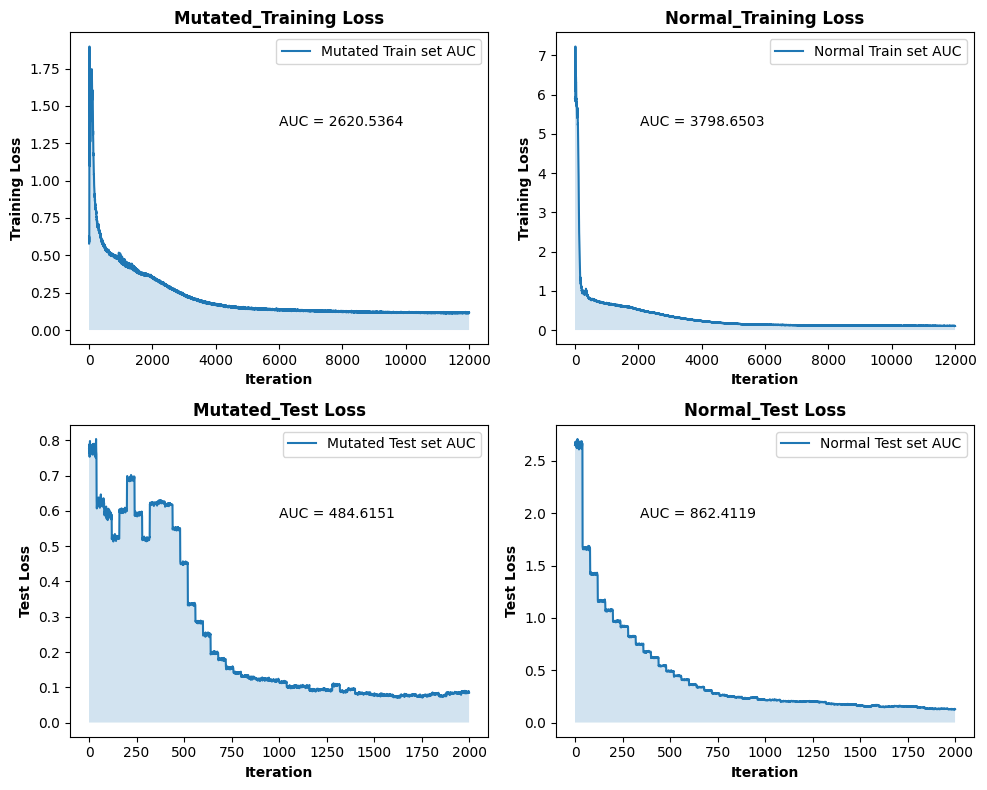

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))



# Plot AUC for training loss in seventh subplot
ax1.plot(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001)
ax1.fill_between(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001, 0, alpha=0.2)
train_auc_0_0001 = auc(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001)
ax1.text(0.5, 0.7, "AUC = " + str(round(train_auc_0_0001, 4)), transform=ax1.transAxes)
ax1.set_title("Mutated_Training Loss", fontweight="bold")
ax1.legend(["Mutated Train set AUC"])
ax1.set_xlabel("Iteration", fontweight="bold")
ax1.set_ylabel("Training Loss", fontweight="bold")



# Plot AUC for training loss in seventh subplot
ax2.plot(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9)
ax2.fill_between(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9, 0, alpha=0.2)
train_auc_0_9 = auc(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9)
ax2.text(0.2, 0.7, "AUC = " + str(round(train_auc_0_9, 4)), transform=ax2.transAxes)
ax2.set_title("Normal_Training Loss", fontweight="bold")
ax2.legend(["Normal Train set AUC" ])
ax2.set_xlabel("Iteration", fontweight="bold")
ax2.set_ylabel("Training Loss", fontweight="bold")


# Plot AUC for training loss in seventh subplot
ax3.plot(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001)
ax3.fill_between(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001, 0, alpha=0.2)
test_auc_0_0001 = auc(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001)
ax3.text(0.5, 0.7, "AUC = " + str(round(test_auc_0_0001, 4)), transform=ax3.transAxes)
ax3.set_title("Mutated_Test Loss", fontweight="bold")
ax3.legend(["Mutated Test set AUC"])
ax3.set_xlabel("Iteration", fontweight="bold")
ax3.set_ylabel("Test Loss", fontweight="bold")



# Plot AUC for training loss in seventh subplot
ax4.plot(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9)
ax4.fill_between(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9, 0, alpha=0.2)
test_auc_0_9 = auc(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9)
ax4.text(0.2, 0.7, "AUC = " + str(round(test_auc_0_9, 4)), transform=ax4.transAxes)
ax4.set_title("Normal_Test Loss", fontweight="bold")
ax4.legend(["Normal Test set AUC" ])
ax4.set_xlabel("Iteration", fontweight="bold")
ax4.set_ylabel("Test Loss", fontweight="bold")


plt.tight_layout()


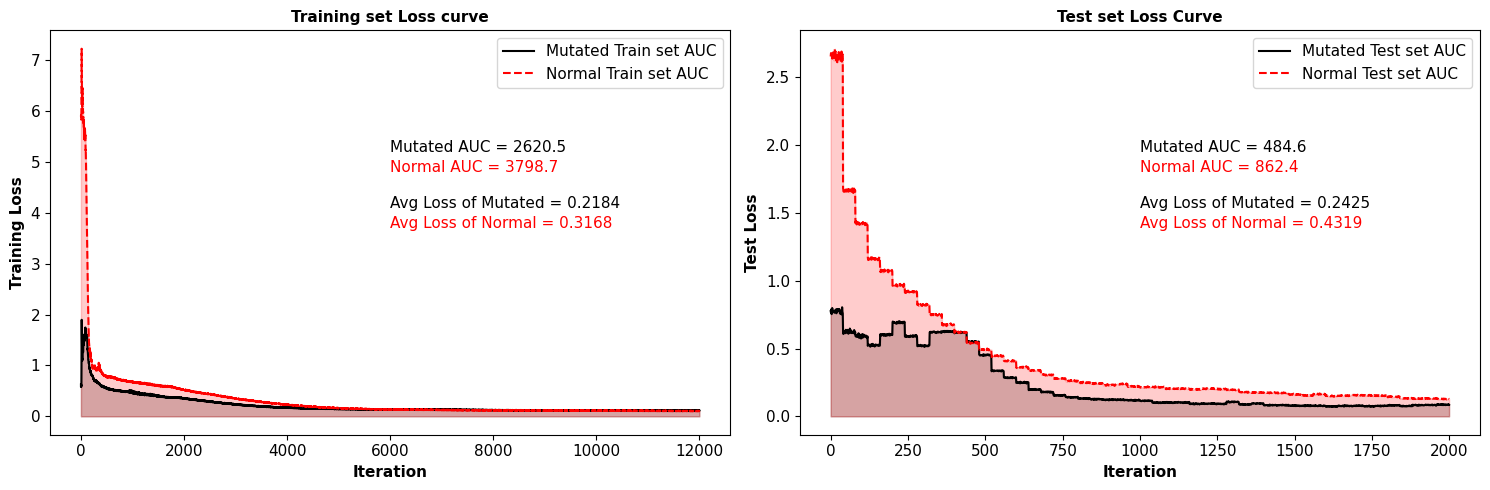

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional color palette
colors = ["#000000", "#FF0000"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 11

# Plot AUC for training loss in the first subplot (ax1)
ax1.plot(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001, color=colors[0], linestyle='-', label="Mutated Train set AUC")
ax1.plot(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal Train set AUC")
ax1.fill_between(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax1.fill_between(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9, 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001)
train_auc_0_9 = auc(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9)
ax1.text(0.5, 0.7, "Mutated AUC = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.65, "Normal AUC = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_loss_rec_0_0001)
train_loss_avg_0_9 = np.mean(train_loss_rec_0_9)
ax1.text(0.5, 0.56, "Avg Loss of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.51, "Avg Loss of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

ax1.set_title("Training set Loss curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training Loss", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test loss in the second subplot (ax2)
ax2.plot(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001, color=colors[0], linestyle='-', label="Mutated Test set AUC")
ax2.plot(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal Test set AUC")
ax2.fill_between(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9, 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001)
test_auc_0_9 = auc(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9)
ax2.text(0.5, 0.7, "Mutated AUC = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
ax2.text(0.5, 0.65, "Normal AUC = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_loss_rec_0_0001)
test_loss_avg_0_9 = np.mean(test_loss_rec_0_9)
ax2.text(0.5, 0.56, "Avg Loss of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
ax2.text(0.5, 0.51, "Avg Loss of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

ax2.set_title("Test set Loss Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Test Loss", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("loss_curves.pdf", bbox_inches="tight")
plt.show()


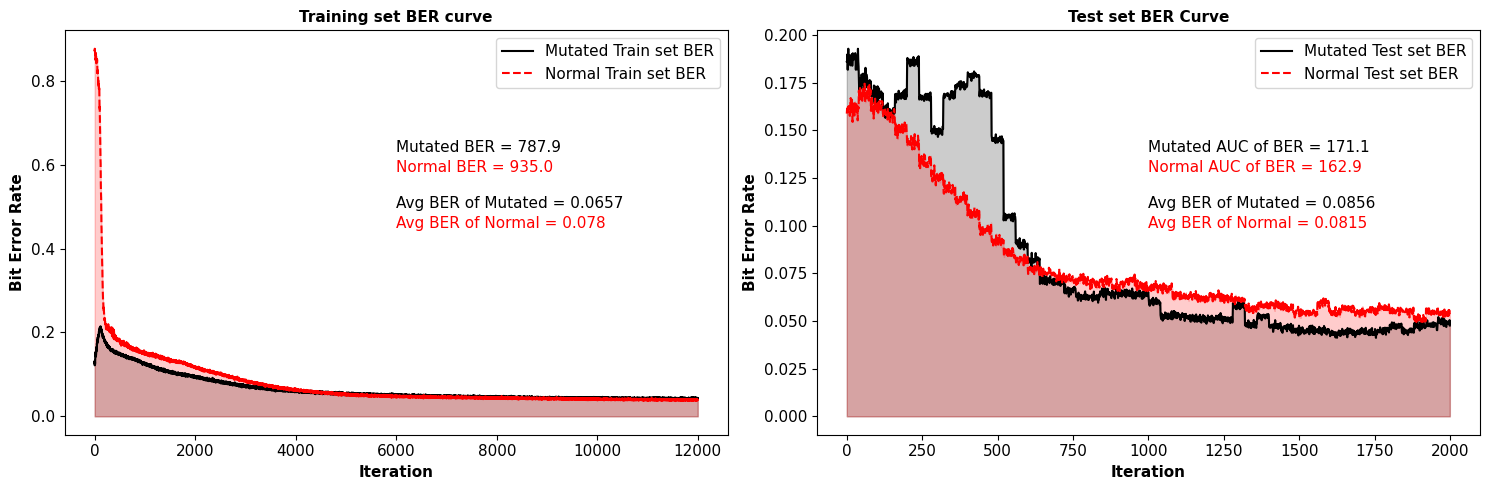

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional color palette
colors = ["#000000", "#FF0000"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 11

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001, color=colors[0], linestyle='-', label="Mutated Train set BER")
ax1.plot(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal Train set BER")
ax1.fill_between(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax1.fill_between(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001)
train_auc_0_9 = auc(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9)
ax1.text(0.5, 0.7, "Mutated BER = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.65, "Normal BER = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_ber_rec_0_0001)
train_loss_avg_0_9 = np.mean(train_ber_rec_0_9)
ax1.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.51, "Avg BER of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

ax1.set_title("Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001, color=colors[0], linestyle='-', label="Mutated Test set BER")
ax2.plot(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal Test set BER")
ax2.fill_between(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001)
test_auc_0_9 = auc(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9)
ax2.text(0.5, 0.7, "Mutated AUC of BER = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
ax2.text(0.5, 0.65, "Normal AUC of BER = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_ber_rec_0_0001)
test_loss_avg_0_9 = np.mean(test_ber_rec_0_9)
ax2.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
ax2.text(0.5, 0.51, "Avg BER of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

ax2.set_title("Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("ber_curves.pdf", bbox_inches="tight")
plt.show()


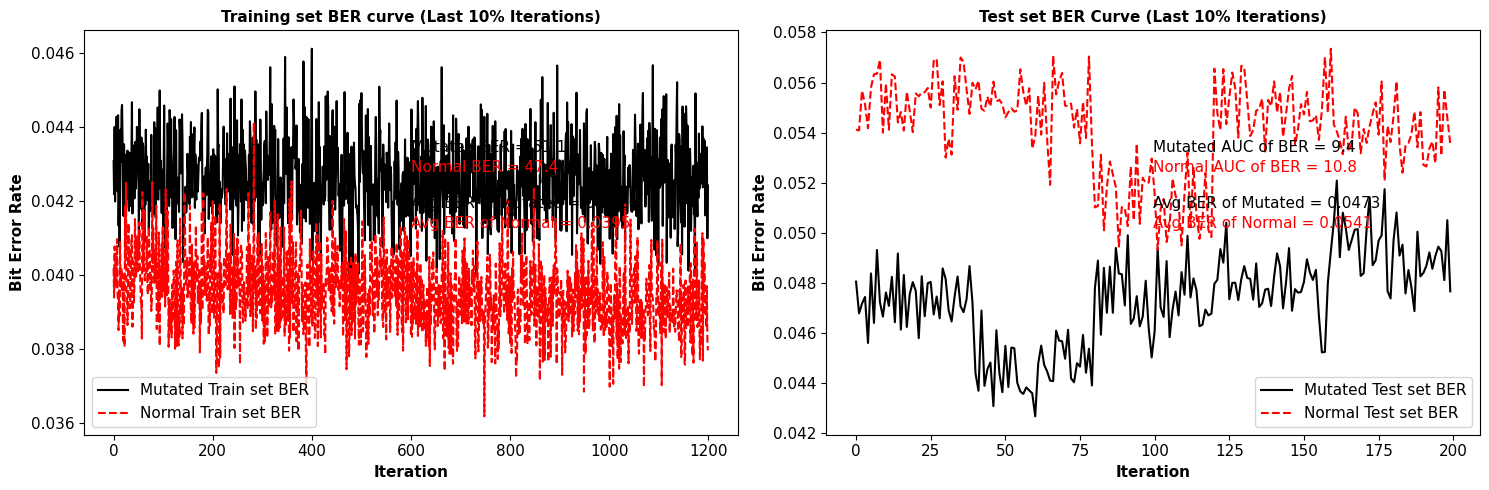

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional color palette
colors = ["#000000", "#FF0000"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 11

# Calculate the index for the last 10% of iterations
last_10_percent_idx_train = int(0.9 * len(train_ber_rec_0_0001))
last_10_percent_idx_test = int(0.9 * len(test_ber_rec_0_0001))

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(len(train_ber_rec_0_0001[last_10_percent_idx_train:])), train_ber_rec_0_0001[last_10_percent_idx_train:], color=colors[0], linestyle='-', label="Mutated Train set BER")
ax1.plot(np.arange(len(train_ber_rec_0_9[last_10_percent_idx_train:])), train_ber_rec_0_9[last_10_percent_idx_train:], color=colors[1], linestyle='--', label="Normal Train set BER")
# ax1.fill_between(np.arange(len(train_ber_rec_0_0001[last_10_percent_idx_train:])), train_ber_rec_0_0001[last_10_percent_idx_train:], 0, alpha=0.2, color=colors[0])
# ax1.fill_between(np.arange(len(train_ber_rec_0_9[last_10_percent_idx_train:])), train_ber_rec_0_9[last_10_percent_idx_train:], 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(len(train_ber_rec_0_0001[last_10_percent_idx_train:])), train_ber_rec_0_0001[last_10_percent_idx_train:])
train_auc_0_9 = auc(np.arange(len(train_ber_rec_0_9[last_10_percent_idx_train:])), train_ber_rec_0_9[last_10_percent_idx_train:])
ax1.text(0.5, 0.7, "Mutated BER = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.65, "Normal BER = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_ber_rec_0_0001[last_10_percent_idx_train:])
train_loss_avg_0_9 = np.mean(train_ber_rec_0_9[last_10_percent_idx_train:])
ax1.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.51, "Avg BER of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

ax1.set_title("Training set BER curve (Last 10% Iterations)", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(len(test_ber_rec_0_0001[last_10_percent_idx_test:])), test_ber_rec_0_0001[last_10_percent_idx_test:], color=colors[0], linestyle='-', label="Mutated Test set BER")
ax2.plot(np.arange(len(test_ber_rec_0_9[last_10_percent_idx_test:])), test_ber_rec_0_9[last_10_percent_idx_test:], color=colors[1], linestyle='--', label="Normal Test set BER")
# ax2.fill_between(np.arange(len(test_ber_rec_0_0001[last_10_percent_idx_test:])), test_ber_rec_0_0001[last_10_percent_idx_test:], 0, alpha=0.2, color=colors[0])
# ax2.fill_between(np.arange(len(test_ber_rec_0_9[last_10_percent_idx_test:])), test_ber_rec_0_9[last_10_percent_idx_test:], 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(len(test_ber_rec_0_0001[last_10_percent_idx_test:])), test_ber_rec_0_0001[last_10_percent_idx_test:])
test_auc_0_9 = auc(np.arange(len(test_ber_rec_0_9[last_10_percent_idx_test:])), test_ber_rec_0_9[last_10_percent_idx_test:])
ax2.text(0.5, 0.7, "Mutated AUC of BER = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
ax2.text(0.5, 0.65, "Normal AUC of BER = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_ber_rec_0_0001[last_10_percent_idx_test:])
test_loss_avg_0_9 = np.mean(test_ber_rec_0_9[last_10_percent_idx_test:])
ax2.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
ax2.text(0.5, 0.51, "Avg BER of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

ax2.set_title("Test set BER Curve (Last 10% Iterations)", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("ber_curves_zoomed.pdf", bbox_inches="tight")
plt.show()


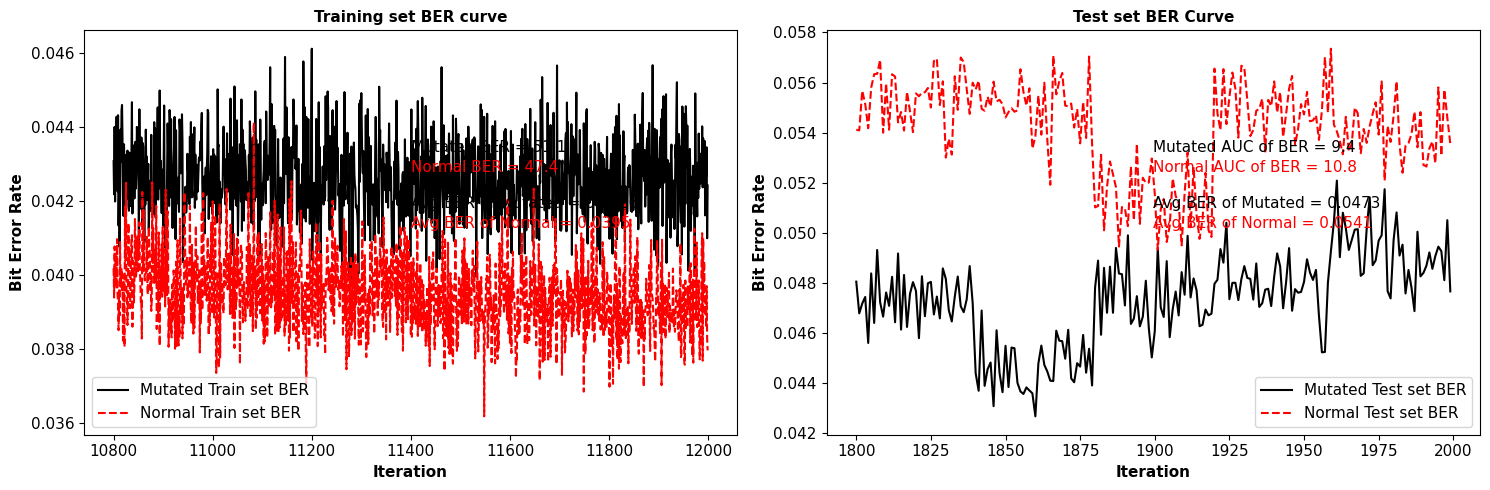

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional color palette
colors = ["#000000", "#FF0000"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 11

# Calculate the index corresponding to the last 10% of iterations
train_last_10_percent_idx = int(0.9 * len(train_ber_rec_0_0001))
test_last_10_percent_idx = int(0.9 * len(test_ber_rec_0_0001))

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:], color=colors[0], linestyle='-', label="Mutated Train set BER")
ax1.plot(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:], color=colors[1], linestyle='--', label="Normal Train set BER")
# ax1.fill_between(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax1.fill_between(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:])
train_auc_0_9 = auc(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:])
ax1.text(0.5, 0.7, "Mutated BER = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.65, "Normal BER = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_ber_rec_0_0001[train_last_10_percent_idx:])
train_loss_avg_0_9 = np.mean(train_ber_rec_0_9[train_last_10_percent_idx:])
ax1.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
ax1.text(0.5, 0.51, "Avg BER of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

ax1.set_title("Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Calculate the index corresponding to the last 10% of iterations for the test set
test_last_10_percent_idx = int(0.9 * len(test_ber_rec_0_0001))

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:], color=colors[0], linestyle='-', label="Mutated Test set BER")
ax2.plot(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:], color=colors[1], linestyle='--', label="Normal Test set BER")
# ax2.fill_between(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax2.fill_between(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:])
test_auc_0_9 = auc(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:])
ax2.text(0.5, 0.7, "Mutated AUC of BER = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
ax2.text(0.5, 0.65, "Normal AUC of BER = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_ber_rec_0_0001[test_last_10_percent_idx:])
test_loss_avg_0_9 = np.mean(test_ber_rec_0_9[test_last_10_percent_idx:])
ax2.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
ax2.text(0.5, 0.51, "Avg BER of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

ax2.set_title("Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels
ax2.ylim = [0.03, 0.07]
plt.tight_layout()

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("ber_curves.pdf", bbox_inches="tight")
plt.show()

